Import the libraries necessary to analize data

In [680]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

In [681]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199379 non-null  datetime64[ns]
 1   state                      199379 non-null  object        
 2   city_or_county             199379 non-null  object        
 3   address                    185728 non-null  object        
 4   latitude                   199313 non-null  float64       
 5   longitude                  199313 non-null  float64       
 6   congressional_district     199379 non-null  float64       
 7   state_house_district       178208 non-null  float64       
 8   state_senate_district      184240 non-null  float64       
 9   participant_age1           136187 non-null  float64       
 10  participant_age_group1     161305 non-null  object        
 11  participant_gender1        166716 non-null  object  

Change data types to match the content of each attribute (setting to NaN non-numerical values in numerical attributes)

In [682]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("float64")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_gender1"] = df["participant_gender1"].astype("string")
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Int64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Int64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Int64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Int64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Int64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Int64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Int64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df["party"] = df["party"].astype("string")
df["candidatevotes"] = df["candidatevotes"].astype("Int64")
df["totalvotes"] = df["totalvotes"].astype("Int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136186 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string  

Deleting the rows with all NaN values

In [683]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 199379
df len after: 199378


Removing negative values

In [684]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


## Age


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived [cite, wikipedia].

In [685]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

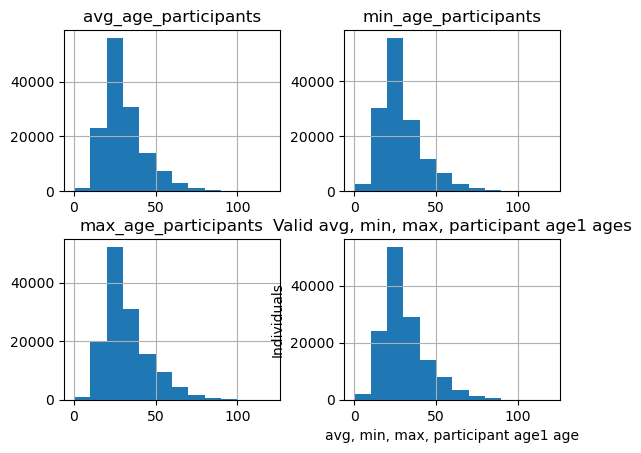

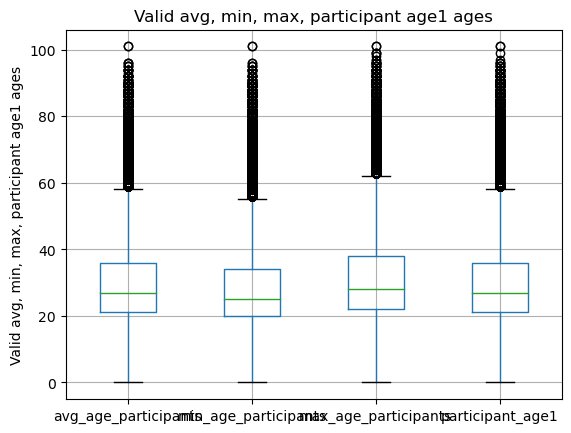

In [686]:

df.hist(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], bins=[i for i in range(0,121,10)])
plt.title("Valid avg, min, max, participant age1 ages")
plt.xlabel("avg, min, max, participant age1 age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'])
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [687]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,136184.000000,136184.000000,136188.000000,136185.000000
mean,29.974858,30.260816,28.325763,31.764746
std,12.461499,13.343577,12.498695,13.709934
min,0.000000,0.000000,0.000000,0.000000
25%,21.000000,21.000000,20.000000,22.000000
50%,27.000000,27.000000,25.000000,28.000000
75%,36.000000,36.000000,34.000000,38.000000
max,101.000000,101.000000,101.000000,101.000000


In [688]:
print(f"% of no child in incidents: {df[df['n_participants_child'] == 0]['n_participants_child'].count() / len(df['n_participants_child'])}")
print(f"% of no teen in incidents: {df[df['n_participants_teen'] == 0]['n_participants_teen'].count() / len(df['n_participants_teen'])}")
print(f"% of no adult in incidents: {df[df['n_participants_adult'] == 0]['n_participants_adult'].count() / len(df['n_participants_adult'])}")

% of no child in incidents: 0.7925949703578128
% of no teen in incidents: 0.7222060608492411
% of no adult in incidents: 0.05159546188646691


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

We check if when avg_age_participants is 0 or null, we can infer it by calcultating the avg based on min_age_participants and max_age_participants, and we found 0 rows available.
This is a further motivation to delete min and max age participants

In [689]:
df[((df['avg_age_participants'] == 0) | (df['avg_age_participants'].isna())) & (((df['min_age_participants'] > 0) & (df['min_age_participants'].notna())) & ((df['max_age_participants'] > 0) & df['min_age_participants'].notna() ))] [['avg_age_participants', 'min_age_participants', 'max_age_participants']]

,avg_age_participants,min_age_participants,max_age_participants


## Date

Analysis and cleaning of the date attribute

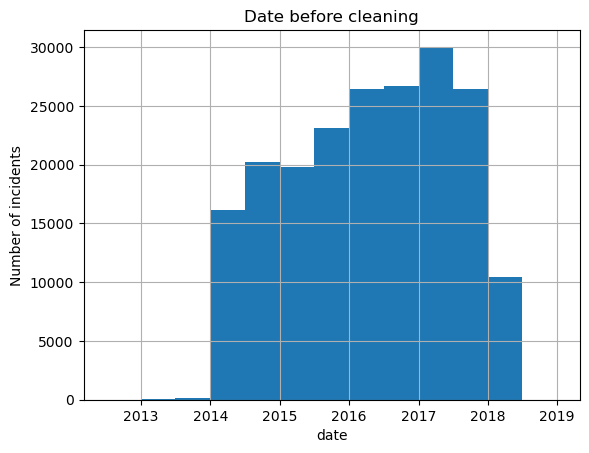

In [690]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

TODO: 2018 analyze separately

As seen in D.U., the year 2013 is under represented with only 242 records, so we decide to drop them. 

In [691]:
df['date'].dt.year.value_counts().sort_index()

2013      242
2014    36331
2015    42934
2016    53082
2017    56373
2018    10416
Name: date, dtype: int64

In [692]:
df_with_2013 = len(df)
df = df[df['date'].dt.year > 2013]
print(df_with_2013 - len(df))

242


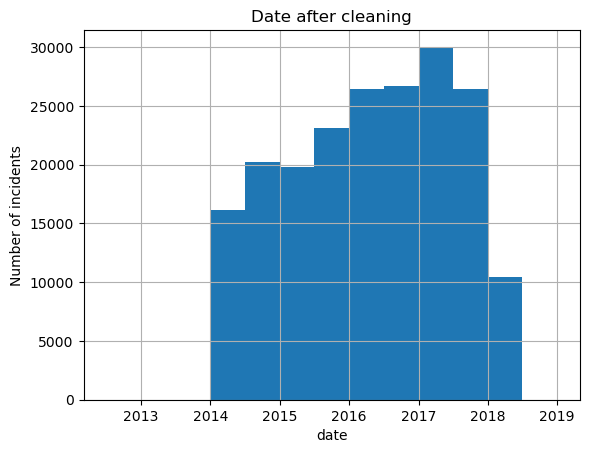

In [693]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date after cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

# Geographical info

## Latitude and longitude

In [694]:
central_block = ((df["latitude"] <= 49.3457868) & (df["latitude"] >= 24.396308) & (df["longitude"] >= -125.000000) & (df["longitude"] <= -66.934570))
alaska_block = ((df["latitude"] <= 71.635993) & (df["latitude"] >= 53.67068) & (df["longitude"] >= -173.59497) & (df["longitude"] <= -129.152344))
hawaii_block = ((df["latitude"] <= 22.674847) & (df["latitude"] >= 17.790535) & (df["longitude"] >= -161.389160) & (df["longitude"] <= -153.237305))

df[~(central_block | alaska_block | hawaii_block)][['latitude', 'longitude']].value_counts(dropna=False)

latitude  longitude
NaN       NaN          66
dtype: int64

We consider the triple <date,latitude,longitude> to be a key identifying an incident. We decided to eliminate the records with these 3 values duplicates. 

In [695]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

latitude  longitude  date      
36.7387   -119.7900  2018-01-16    6
                     2018-03-17    5
32.7485   -93.9895   2017-01-18    4
32.5512   -93.7045   2016-04-16    4
42.3482   -83.0618   2016-07-04    4
                                  ..
33.6356   -84.4333   2014-02-02    2
                     2014-07-09    2
                     2014-10-09    2
                     2014-10-10    2
61.6139   -149.4510  2016-07-28    2
Length: 1134, dtype: int64

In [696]:
print(len(df))
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(len(df))

199136


197925


In [697]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

Series([], dtype: int64)

## Filling of missing values and outliers

In [698]:
#Sostituisco i valori NaN di latitude e longitude, con i valori delle righe aventi lo stesso state e la stessa city_or_county
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']].isna().any()

latitude     False
longitude    False
dtype: bool

## Congressional District, State House District, State Senate District

By examining the columns ‘congressional_district’, ‘state_house_district’, and ‘state_senate_district’, we observe that the columns ‘state_house_district’ and ‘state_senate_district’ represent further subdivisions of the US territory, which are not pertinent to our analysis. We will utilize the ‘congressional_district’ column to study the territorial divisions.

In [699]:
df.drop(columns=['state_house_district', 'state_senate_district'], inplace=True)

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

#TODO to check..

In [700]:
len(df)

197925

In [701]:
df.loc[df["n_participants"] == 0, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]] = 0

In [702]:
#Utilizzerà questi valori per sosituire "n_participants" nel caso somma tra male e female è pari alla somma tra teen,child e adults.
#La modifica per quanto riguarda "n_participants" è fatta solo se è diversa da tutte le altre somme delle varie colonne:
#1) females + males
#2) child + adult + teen
#3) killed+injured+unharmed+arrested

#Nel caso in cui n_participants sia almeno uguale ad una delle altre somme => lascia uguale.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult'])) &
    (df['n_participants'] != (df['n_females'] + df['n_males'])) 
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[condition][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult"]]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
163920,1,1,0,0,0,1
172845,1,1,0,0,0,1
57,1,1,0,0,0,1
63,1,0,1,0,0,1
170,1,1,0,0,0,1
...,...,...,...,...,...,...
198882,1,0,1,0,0,1
198900,1,0,1,0,0,1
198906,1,1,0,0,0,1
198932,2,0,2,0,1,1


In [703]:
condition = (
    ((df['n_females'] + df['n_males']) != (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

condition1 = condition & ((df['n_participants'] == (df['n_females'] + df['n_males'])))

print(f"Same condition as before but with n participants == female + male: {len(df[condition1])}")

condition2 = condition & ((df['n_participants'] == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult'])) )

print(f"Same condition as before but with n participants == child + teen + adult: {len(df[condition2])}")

condition3 = condition & (((df['n_participants'] != (df['n_females'] + df['n_males'])) & (df['n_participants'] != (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))))
                          
print(f"Same condition as before but with n participants != child + teen + adult and != n_males + n_females: {len(df[condition3])}")


Number of male e female != child + teen + adult:  13364
Same condition as before but with n participants == female + male: 8650
Same condition as before but with n participants == child + teen + adult: 4202
Same condition as before but with n participants != child + teen + adult and != n_males + n_females: 512


In [704]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197925 entries, 85424 to 199339
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       197925 non-null  datetime64[ns]
 1   state                      197925 non-null  string        
 2   city_or_county             197925 non-null  string        
 3   address                    184534 non-null  string        
 4   latitude                   197925 non-null  float64       
 5   longitude                  197925 non-null  float64       
 6   congressional_district     197925 non-null  Int64         
 7   participant_age1           135327 non-null  Int64         
 8   participant_age_group1     160339 non-null  string        
 9   participant_gender1        165727 non-null  string        
 10  min_age_participants       135331 non-null  Int64         
 11  avg_age_participants       135327 non-null  floa

In [705]:
df.loc[condition3, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]] = np.nan
df.loc[condition2, ["n_males","n_females"]] = np.nan
df.loc[condition1, ["n_participants_child","n_participants_teen", "n_participants_adult"]] = np.nan

In [706]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197925 entries, 85424 to 199339
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       197925 non-null  datetime64[ns]
 1   state                      197925 non-null  string        
 2   city_or_county             197925 non-null  string        
 3   address                    184534 non-null  string        
 4   latitude                   197925 non-null  float64       
 5   longitude                  197925 non-null  float64       
 6   congressional_district     197925 non-null  Int64         
 7   participant_age1           135327 non-null  Int64         
 8   participant_age_group1     160339 non-null  string        
 9   participant_gender1        165727 non-null  string        
 10  min_age_participants       135331 non-null  Int64         
 11  avg_age_participants       135327 non-null  floa

In [715]:
#putting in males the first element from males_females
group_by_df = df.groupby("n_participants")[["n_males","n_females"]]

for name, group in group_by_df:
    group["n_males"] = group["n_males"].fillna(group["n_males"].mode(dropna = False)[0])
    group["n_females"] = group["n_females"].fillna(group["n_females"].mode(dropna = False)[0])

group_by_df = df.groupby("n_participants")[["n_participants_child","n_participants_teen",'n_participants_adult']]

for name, group in group_by_df:
    print(name)
    print(group["n_participants_adult"].mode(dropna = False))
    group["n_participants_child"] = group["n_participants_child"].fillna(group["n_participants_child"].mode(dropna = False)[0])
    group["n_participants_teen"] = group["n_participants_teen"].fillna(group["n_participants_teen"].mode(dropna = False)[0])
    group["n_participants_adult"] = group["n_participants_adult"].fillna(group["n_participants_adult"].mode(dropna = False)[0])
    


KeyError: 'n_males'

In [713]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197925 entries, 85424 to 199339
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       197925 non-null  datetime64[ns]
 1   state                      197925 non-null  string        
 2   city_or_county             197925 non-null  string        
 3   address                    184534 non-null  string        
 4   latitude                   197925 non-null  float64       
 5   longitude                  197925 non-null  float64       
 6   congressional_district     197925 non-null  Int64         
 7   participant_age1           135327 non-null  Int64         
 8   participant_age_group1     160339 non-null  string        
 9   participant_gender1        165727 non-null  string        
 10  min_age_participants       135331 non-null  Int64         
 11  avg_age_participants       135327 non-null  floa

All the wrong data were corrected

In [709]:
condition = (
    ((df['n_females'] + df['n_males']) != (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

Number of male e female != child + teen + adult:  0


In [710]:
df[['n_participants',"n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].head(100)

,n_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
85424,1,0,1,<NA>,<NA>,<NA>
87060,1,0,0,<NA>,<NA>,<NA>
154437,2,0,0,<NA>,<NA>,<NA>
162475,1,0,0,<NA>,<NA>,<NA>
162702,1,0,0,<NA>,<NA>,<NA>
...,...,...,...,...,...,...
29,4,0,0,<NA>,<NA>,<NA>
30,2,0,0,<NA>,<NA>,<NA>
31,2,0,0,<NA>,<NA>,<NA>
32,2,0,0,<NA>,<NA>,<NA>


# Poverty by State

# Year State District House

# Correlation Matrix Analysis

In [711]:
corr_matrix = df[['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'povertyPercentage']].corr(numeric_only=True, method='pearson')
corr_matrix

TypeError: corr() got an unexpected keyword argument 'numeric_only'

<Axes: >

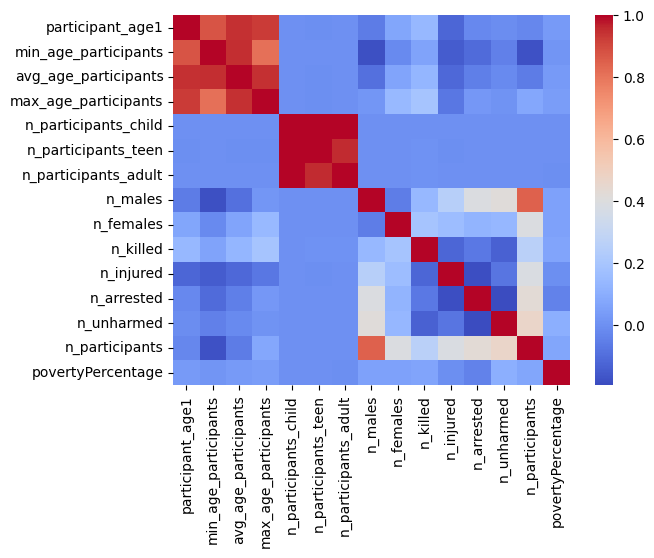

In [ ]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

# Definition of Index 

In [ ]:
#How many males are involved in incidents w.r.t. the total number of males for the
#same city and in the same period?
df["males_percentage"] = df["n_males"] /  df.groupby(["year","state", "city_or_county"])["n_males"].transform("sum")
df["males_percentage"]

85424          1.0
87060     0.066667
154437    0.002506
162475         1.0
162702    0.021277
            ...   
199335         1.0
199336         1.0
199337         NaN
199338         1.0
199339         1.0
Name: males_percentage, Length: 197925, dtype: Float64

In [ ]:
#How many killed people have been involved w.r.t the total killed people in
# the same congressional district in a given period of time?
df["killed_percentage"] = df["n_killed"] /  df.groupby(["year","state", "congressional_district" ])["n_killed"].transform("sum")
df["killed_percentage"]

85424     0.0
87060     0.0
154437    0.0
162475    0.0
162702    0.0
         ... 
199335    NaN
199336    NaN
199337    NaN
199338    NaN
199339    NaN
Name: killed_percentage, Length: 197925, dtype: Float64

In [ ]:
#How many injured people have been involved w.r.t the total injured people in
# the same congressional district in a given period of time?
df["injured_percentage"] = df["n_injured"] /  df.groupby(["year","state", "congressional_district" ])["n_injured"].transform("sum")


In [ ]:
#Ratio of the number of the killed people in the incidents w.r.t. the number of
#participants in the incident
df["killed_percentage_per_incident"] = df["n_killed"] / df["n_participants"]
df[["n_killed", "n_participants", "killed_percentage_per_incident"]]

,n_killed,n_participants,killed_percentage_per_incident
85424,0,1,0.0
87060,0,1,0.0
154437,0,2,0.0
162475,0,1,0.0
162702,0,1,0.0
...,...,...,...
199335,0,2,0.0
199336,0,1,0.0
199337,0,1,0.0
199338,0,3,0.0


In [ ]:
#Ratio of unharmed people in the incidents w.r.t. the the average of unharmed people
#in the same period
df["unharmed_percentage"] = df["n_unharmed"] / df.groupby(["year"])["n_unharmed"].transform("mean")
df[["n_unharmed", "unharmed_percentage"]]

,n_unharmed,unharmed_percentage
85424,0,0.0
87060,0,0.0
154437,0,0.0
162475,0,0.0
162702,0,0.0
...,...,...
199335,0,0.0
199336,1,3.49192
199337,0,0.0
199338,0,0.0


# Attributes dropped

As observed in the DU address will be dropped, moreover we will drop also year and notes because the former is a result of the data integration, useless because is redundant as we have the attribute date, the latter is useless because is only a string of text, used only in the data understanding

In [ ]:
df.drop(columns=['notes', 'year', 'address'], inplace=True)

# Export the dataframe after the data preparation

In [ ]:
df.to_csv('df_after_dp.csv', index=False)